# Data Analysis on Precision Agriculture

## Business Understanding
Machine Learning in precision agriculture comes with the idea of optimizing the usage of pesticides using smart devices. However, the use of excessive pesticides leads to high amount of crop damage which can result in a negative effect towards the agriculture. This can prove to be harmful in terms of generating a higher yield for the crop. A good harvest is ensured by several factors such as availability of water, soil fertility, protecting crops from rodents, timely use of pesticides & other useful chemicals and nature. While a lot of these factors are difficult to control for, the amount and frequency of pesticides is something the farmer can control.

Pesticides are also special, because while they protect the crop with the right dosage. But, if you add more than required, they may spoil the entire harvest. A high level of pesticide can deem the crop dead / unsuitable for consumption among many outcomes. This data is based on crops harvested by various farmers at the end of harvest season. To simplify the problem, you can assume that all other factors like variations in farming techniques have been controlled for.

## Data Understanding

The target variable is the Crop Damage which essentially refers to the damage done to the crop due to excessive pesticide usage (referring to be either 0 or 1, which indicates not damaged and damaged respectively). Hence, it is a binary classification problem.

The input variables in the problem are:

1. ID: Unique ID (object)
2. Estimated_Insects_Count: The number of insects on the crop (int64)
3. Crop_Type: The category of the crop (0, 1) (int64)
4. Soil_Type: The category of the soil (0, 1) (int64)
5. Pesticide_Use_Category: Type of pesticides uses (1- Never, 2-Previously Used, 3-Currently Using) (int64)
6. Number_Doses_Week: Number of Doses per week (int64)
7. Number_Weeks_Used: Number of weeks used (float64)
8. Number_Weeks_Quit: Number of weeks quitted (int64)
9. Season: Season Category (1, 2, 3)

Hence we have a single target variable, and 9 input features to deal with.
The expected output file should contain Unique ID along with the indicated crop damage.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [50]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

In [51]:
train = pd.read_csv("/content/drive/My Drive/train.csv", encoding="utf-8")
test = pd.read_csv("/content/drive/My Drive/test.csv", encoding="utf-8")

In [52]:
train['train_flag'] = 1
test['train_flag'] = 0
test['Crop_Damage'] = 0

print(train.shape, test.shape)

(88858, 11) (59310, 11)


In [53]:

data = pd.concat([train, test])
data.shape

(148168, 11)

In [54]:
features = data.columns.tolist()
features.remove('ID')
features.remove('Crop_Damage')
features.remove('train_flag')
label_col = 'Crop_Damage'
print(features)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [55]:
data.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag
0,F00000001,188,1,0,1,0,0.0,0,1,0,1
1,F00000003,209,1,0,1,0,0.0,0,2,1,1
2,F00000004,257,1,0,1,0,0.0,0,2,1,1
3,F00000005,257,1,1,1,0,0.0,0,2,1,1
4,F00000006,342,1,0,1,0,0.0,0,2,1,1


In [56]:
data['ID_Value'] = data['ID'].apply(lambda x: x.strip('F')).astype(int)
data.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_Value
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1
1,F00000003,209,1,0,1,0,0.0,0,2,1,1,3
2,F00000004,257,1,0,1,0,0.0,0,2,1,1,4
3,F00000005,257,1,1,1,0,0.0,0,2,1,1,5
4,F00000006,342,1,0,1,0,0.0,0,2,1,1,6


In [57]:
data = data.sort_values(['ID_Value'])

In [58]:
data = data.reset_index(drop=True)
data.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_Value
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1
1,F00000002,188,1,1,1,0,NaN,0,2,0,0,2
2,F00000003,209,1,0,1,0,0.0,0,2,1,1,3
3,F00000004,257,1,0,1,0,0.0,0,2,1,1,4
4,F00000005,257,1,1,1,0,0.0,0,2,1,1,5


In [59]:
def data_info(data, data_types, dataframe_name):
    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")
    data.info()
    print("\n")
    for VARIABLE in data_types:
        data_type = data.select_dtypes(include=[VARIABLE]).dtypes
        if len(data_type) > 0:
            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        


data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
data_info(data, data_types, "train")

 Information of  train : Rows =  148168 | Columns =  12 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148168 entries, 0 to 148167
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       148168 non-null  object 
 1   Estimated_Insects_Count  148168 non-null  int64  
 2   Crop_Type                148168 non-null  int64  
 3   Soil_Type                148168 non-null  int64  
 4   Pesticide_Use_Category   148168 non-null  int64  
 5   Number_Doses_Week        148168 non-null  int64  
 6   Number_Weeks_Used        133275 non-null  float64
 7   Number_Weeks_Quit        148168 non-null  int64  
 8   Season                   148168 non-null  int64  
 9   Crop_Damage              148168 non-null  int64  
 10  train_flag               148168 non-null  int64  
 11  ID_Value                 148168 non-null  int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 13.6+ 

In [60]:
def display_head_tail(data, head_size=5, tail_size=5):
  print("The head and tail of the data is given as follows:")
  display(data.head(head_size).append(data.tail(tail_size)))

display_head_tail(data, 3, 3)

The head and tail of the data is given as follows:


,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_Value
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1
1,F00000002,188,1,1,1,0,NaN,0,2,0,0,2
2,F00000003,209,1,0,1,0,0.0,0,2,1,1,3
148165,F00155943,3702,1,0,2,10,28.0,17,2,0,0,155943
148166,F00155944,3895,1,0,2,5,52.0,7,1,0,0,155944
148167,F00155945,3895,1,0,2,20,37.0,7,3,0,1,155945


In [61]:
def remove_duplicates(data):
  print("Before Removing Duplicate Data: ", data.shape[0])
  data.drop_duplicates(keep='first', inplace=True)
  print("After Removing Duplicate Data: ", data.shape[0])
remove_duplicates(data)

Before Removing Duplicate Data:  148168
After Removing Duplicate Data:  148168


In [62]:
def handle_missing_values(data, fill_value, fill_types, columns, dataframe_name):
  print("Missing Values BEFORE REMOVAL in ", dataframe_name)
  display(data.isna().sum())
  for column in columns :
        
      # Fill Missing Values with Specific Value :
      if "Value_Fill" in fill_types :
          data[ column ] = data[ column ].fillna(fill_value)
#            print("Value_Fill")

        # Fill Missing Values with Forward Fill  (Previous Row Value as Current Row in Table) :
      if "Forward_Fill" in fill_types :
          data[ column ] = data[ column ].ffill(axis = 0)
#            print("Forward_Fill")

        # Fill Missing Values with Backward Fill (Next Row Value as Current Row in Table) :
      if "Backward_Fill" in fill_types :
          data[ column ] = data[ column ].bfill(axis = 0)
#             print("Backward_Fill")
    
  print("Missing Values AFTER REMOVAL in ",dataframe_name," data")
  display(data.isnull().sum())
    
  return data

fill_types = [ "Forward_Fill"]
# Median Replacement of Null values
fill_value = train["Number_Weeks_Used"].median()
train = handle_missing_values(data, fill_value, fill_types, ["Number_Weeks_Used"],"train")

Missing Values BEFORE REMOVAL in  train


ID                             0
Estimated_Insects_Count        0
Crop_Type                      0
Soil_Type                      0
Pesticide_Use_Category         0
Number_Doses_Week              0
Number_Weeks_Used          14893
Number_Weeks_Quit              0
Season                         0
Crop_Damage                    0
train_flag                     0
ID_Value                       0
dtype: int64

Missing Values AFTER REMOVAL in  train  data


ID                         0
Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
train_flag                 0
ID_Value                   0
dtype: int64

In [63]:
def unique_values(data):
  for column in data.columns:
    print("Number of unique values are: ", str(data[column].nunique()))
    print("Actual Unique Values in "+column+" Column are : "+
          str(data[column].sort_values(ascending=True,na_position='last').unique() ))
    print("Value Counts :")
    print(data[column].value_counts())
    print("")
unique_values(data)

Number of unique values are:  148168
Actual Unique Values in ID Column are : ['F00000001' 'F00000002' 'F00000003' ... 'F00155943' 'F00155944'
 'F00155945']
Value Counts :
F00117747    1
F00060158    1
F00073364    1
F00140698    1
F00017598    1
            ..
F00118036    1
F00067572    1
F00100474    1
F00012722    1
F00100616    1
Name: ID, Length: 148168, dtype: int64

Number of unique values are:  71
Actual Unique Values in Estimated_Insects_Count Column are : [ 150  151  168  169  188  209  231  232  256  257  283  311  312  342
  375  410  411  448  488  489  531  577  625  626  677  731  732  789
  790  850  851  915  916  984 1056 1132 1212 1296 1297 1385 1478 1575
 1576 1678 1785 1786 1898 2015 2016 2138 2139 2267 2401 2402 2541 2542
 2687 2688 2840 2999 3164 3165 3336 3337 3515 3516 3702 3895 3896 4096
 4097]
Value Counts :
1132    5664
1212    5639
1478    5590
1385    5580
1056    5368
        ... 
3896     237
3515     220
4097     194
231      150
169      103
Name: Esti

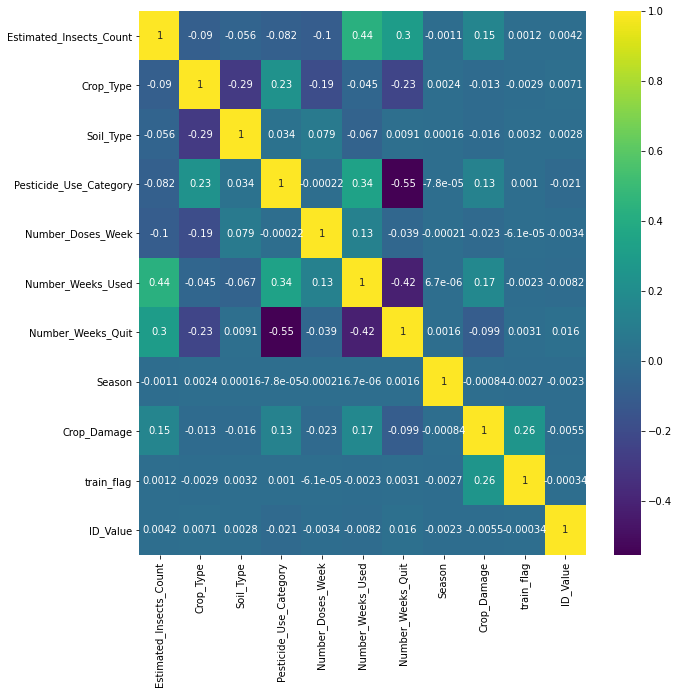

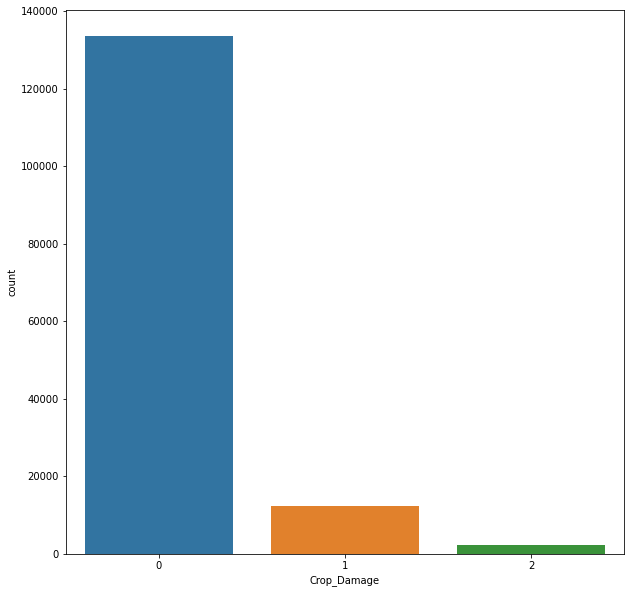

In [64]:
def heatmap(df):
  plt.figure(figsize=(10,10))
  corr = df.corr()
  return sns.heatmap(corr, annot=True, cmap='viridis')

def cntplt(df, feature):
  plt.figure(figsize=(10, 10))
  return sns.countplot(data=df, x=df[feature])

heatmap(data)
cntplt(data, 'Crop_Damage')

The data is highly imbalanced and can be in need of oversampling before running the model. However, in a real time use perspective we can also say that the amount of crops damaged due to excessive pesticides can actually be low, and hence the data is justified as it is. However, for a generalized model, we will try handling the imbalance in the class.

Let us try to answer a few more questions:

## Is there any relation between the Season and Crops Damaged?
- Season 2 has the highest number of damaged crops, although the count of the insects does not remain high during the Season 2 compared to other seasons, which can mean that the insects are more actively eating crops during Season 2 which justifies the damage done.
## Is there any relation between type of crop and damages?

- Yes, crop 2 has higher number of damaged crops.

## Is a particular pesticide causing more damage than others?
- Pesticide 2 seems to have an overall neutralizing effect in either cases since it has caused maximum crop damage, and at same time has caused 

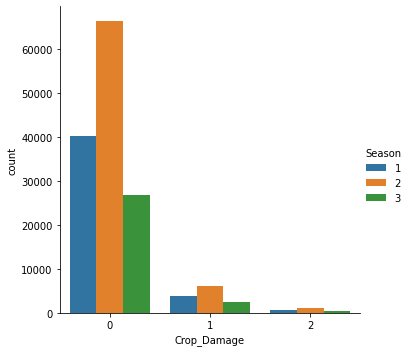

In [ ]:
# Season 2 is the most damaging season for a crop
sns.catplot(x="Crop_Damage", hue="Season", kind="count", data=data);

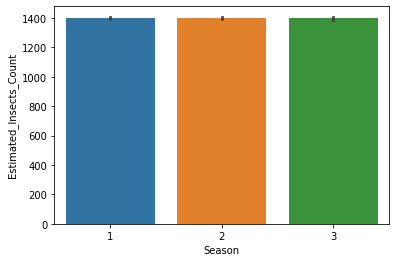

In [ ]:
# All seasons have almost same estimated insects, hence we can say that Season 2 
# is the active period for the insects
sns.barplot(x='Season', y='Estimated_Insects_Count', data=data)

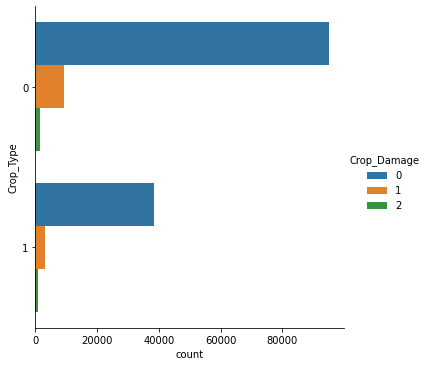

In [ ]:
sns.catplot(y='Crop_Type', hue='Crop_Damage', kind='count', data=data)

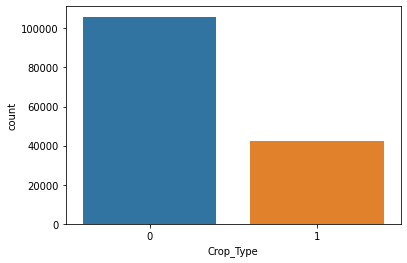

In [ ]:
# Clearly, there is imbalance within type of crop as well
sns.countplot(x='Crop_Type', data=data)

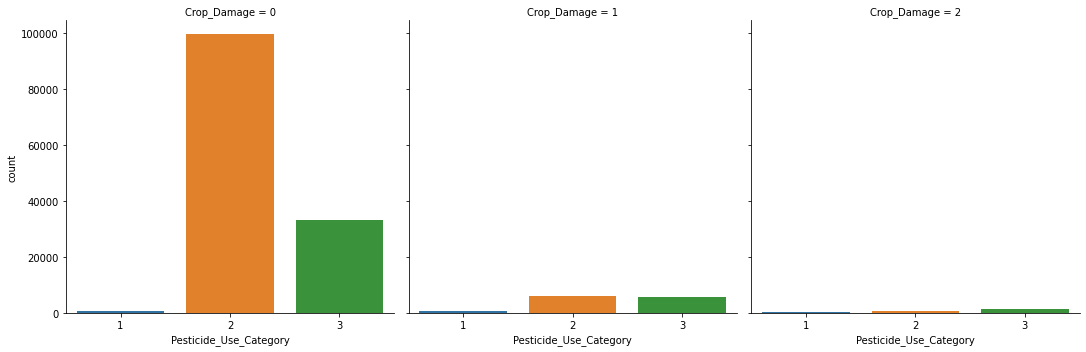

In [ ]:
sns.catplot(x='Pesticide_Use_Category', col='Crop_Damage', kind='count', data=data)

In [65]:
def timeseries(data, new_feature, old_feature):
  data[new_feature] = data.sort_values(['ID_Value']).groupby([old_feature])['Crop_Damage'].apply(lambda x: x.shift().rolling(10, min_periods=1).mean()).fillna(-999).values
  return data
timeseries(data, 'Pesticide_Use_Category_Damage', 'Pesticide_Use_Category')
timeseries(data, 'Estimated_Insects_Count_Damage', 'Estimated_Insects_Count')
timeseries(data, 'Crop_Type_Damage', 'Crop_Type')
timeseries(data, 'Soil_Type_Damage', 'Soil_Type')
timeseries(data, 'Number_Doses_Week_Damage', 'Number_Doses_Week')
timeseries(data, 'Number_Weeks_Used_Damage', 'Number_Weeks_Used')
timeseries(data, 'Number_Weeks_Quit_Damage', 'Number_Weeks_Quit')
timeseries(data, 'Season_Damage', 'Season')

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_Value,Pesticide_Use_Category_Damage,Estimated_Insects_Count_Damage,Crop_Type_Damage,Soil_Type_Damage,Number_Doses_Week_Damage,Number_Weeks_Used_Damage,Number_Weeks_Quit_Damage,Season_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000
1,F00000002,188,1,1,1,0,0.0,0,2,0,0,2,0.000000,0.0,0.000000,-999.0,0.000000,0.000000,0.000000,-999.000000
2,F00000003,209,1,0,1,0,0.0,0,2,1,1,3,0.000000,-999.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,F00000004,257,1,0,1,0,0.0,0,2,1,1,4,0.333333,-999.0,0.333333,0.5,0.333333,0.333333,0.333333,0.500000
4,F00000005,257,1,1,1,0,0.0,0,2,1,1,5,0.500000,1.0,0.500000,0.0,0.500000,0.500000,0.500000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148163,F00155941,3702,1,0,2,10,32.0,48,1,0,0,155941,0.000000,0.3,0.000000,0.0,0.100000,0.000000,0.300000,0.000000
148164,F00155942,3702,1,0,2,10,25.0,18,3,0,1,155942,0.000000,0.3,0.000000,0.0,0.100000,0.100000,0.000000,0.000000
148165,F00155943,3702,1,0,2,10,28.0,17,2,0,0,155943,0.000000,0.3,0.000000,0.0,0.100000,0.000000,0.000000,0.100000
148166,F00155944,3895,1,0,2,5,52.0,7,1,0,0,155944,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [66]:
data.loc[data['train_flag'] == 0, 'Crop_Damage'] = -999
data.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_Value,Pesticide_Use_Category_Damage,Estimated_Insects_Count_Damage,Crop_Type_Damage,Soil_Type_Damage,Number_Doses_Week_Damage,Number_Weeks_Used_Damage,Number_Weeks_Quit_Damage,Season_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000
1,F00000002,188,1,1,1,0,0.0,0,2,-999,0,2,0.000000,0.0,0.000000,-999.0,0.000000,0.000000,0.000000,-999.000000
2,F00000003,209,1,0,1,0,0.0,0,2,1,1,3,0.000000,-999.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,F00000004,257,1,0,1,0,0.0,0,2,1,1,4,0.333333,-999.0,0.333333,0.5,0.333333,0.333333,0.333333,0.500000
4,F00000005,257,1,1,1,0,0.0,0,2,1,1,5,0.500000,1.0,0.500000,0.0,0.500000,0.500000,0.500000,0.666667


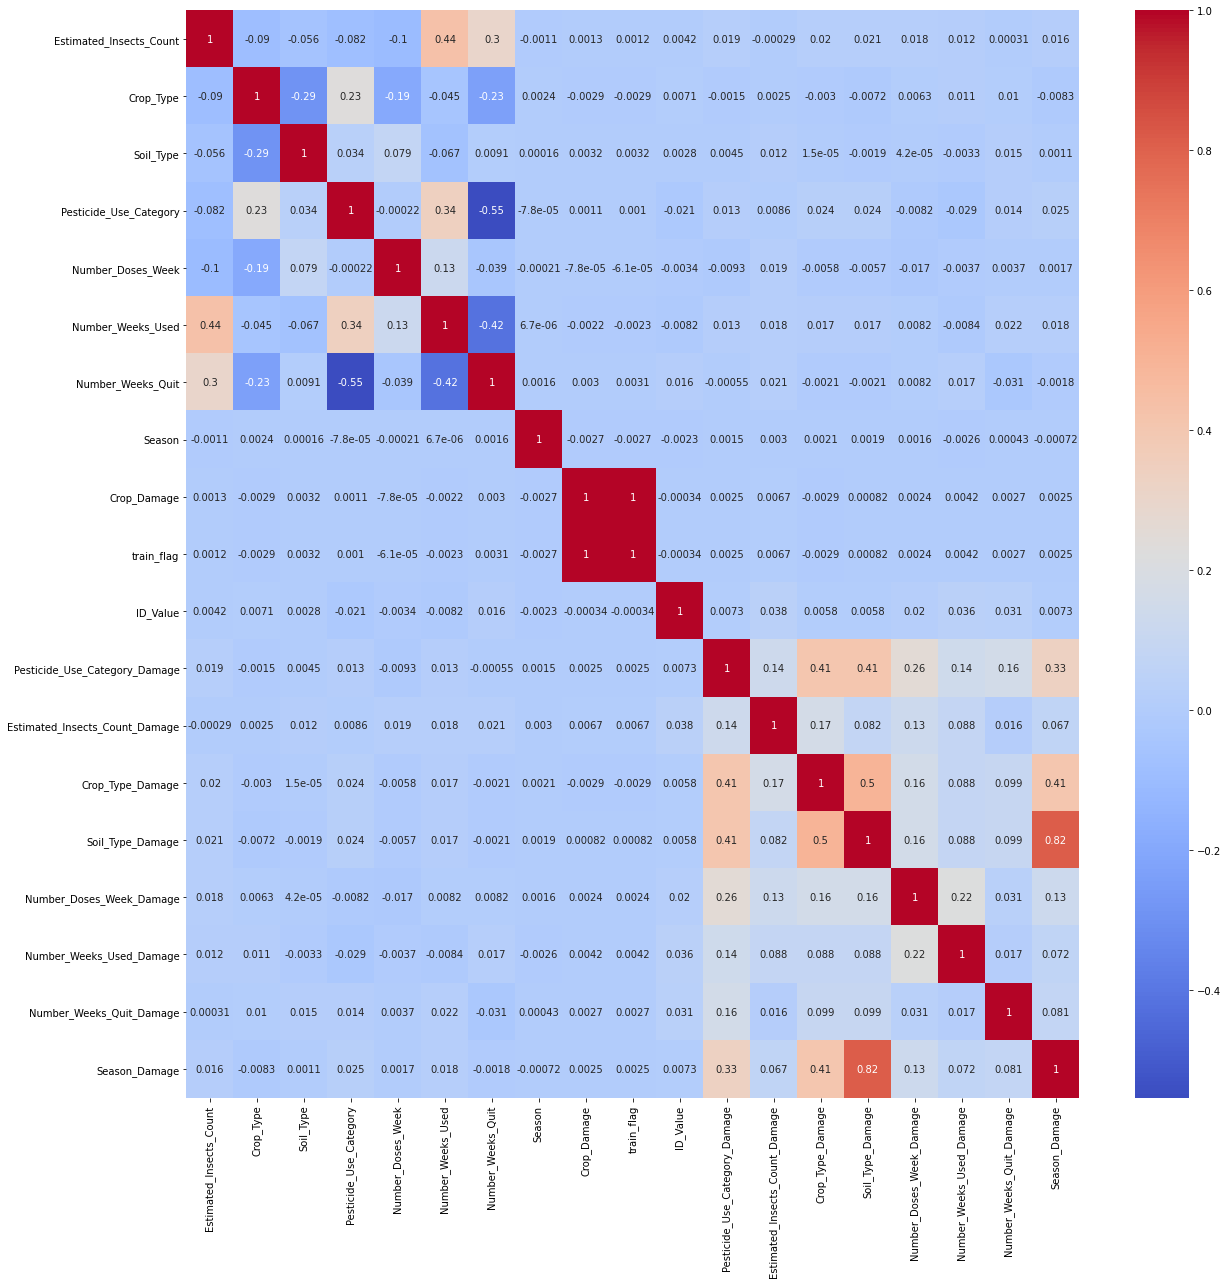

In [67]:
corr = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [68]:
def first_lag(data, new_feature, old_feature):
  data[new_feature] = data[old_feature].shift(fill_value=-99)
  return data

first_lag(data, 'Estimated_Insects_Count_Lag_1', 'Estimated_Insects_Count')
first_lag(data, 'Crop_Type_Lag_1', 'Crop_Type')
first_lag(data, 'Soil_Type_Lag_1', 'Soil_Type')
first_lag(data, 'Pesticide_Use_Category_Lag_1', 'Pesticide_Use_Category')
first_lag(data, 'Number_Doses_Week_Lag_1', 'Number_Doses_Week')
first_lag(data, 'Number_Weeks_Used_Lag_1', 'Number_Weeks_Used')
first_lag(data, 'Season_Lag_1', 'Season')

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_Value,Pesticide_Use_Category_Damage,Estimated_Insects_Count_Damage,Crop_Type_Damage,Soil_Type_Damage,Number_Doses_Week_Damage,Number_Weeks_Used_Damage,Number_Weeks_Quit_Damage,Season_Damage,Estimated_Insects_Count_Lag_1,Crop_Type_Lag_1,Soil_Type_Lag_1,Pesticide_Use_Category_Lag_1,Number_Doses_Week_Lag_1,Number_Weeks_Used_Lag_1,Season_Lag_1
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-99,-99,-99,-99,-99,-99.0,-99
1,F00000002,188,1,1,1,0,0.0,0,2,-999,0,2,0.000000,0.0,0.000000,-999.0,0.000000,0.000000,0.000000,-999.000000,188,1,0,1,0,0.0,1
2,F00000003,209,1,0,1,0,0.0,0,2,1,1,3,0.000000,-999.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,188,1,1,1,0,0.0,2
3,F00000004,257,1,0,1,0,0.0,0,2,1,1,4,0.333333,-999.0,0.333333,0.5,0.333333,0.333333,0.333333,0.500000,209,1,0,1,0,0.0,2
4,F00000005,257,1,1,1,0,0.0,0,2,1,1,5,0.500000,1.0,0.500000,0.0,0.500000,0.500000,0.500000,0.666667,257,1,0,1,0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148163,F00155941,3702,1,0,2,10,32.0,48,1,-999,0,155941,0.000000,0.3,0.000000,0.0,0.100000,0.000000,0.300000,0.000000,3516,1,0,2,20,32.0,2
148164,F00155942,3702,1,0,2,10,25.0,18,3,0,1,155942,0.000000,0.3,0.000000,0.0,0.100000,0.100000,0.000000,0.000000,3702,1,0,2,10,32.0,1
148165,F00155943,3702,1,0,2,10,28.0,17,2,-999,0,155943,0.000000,0.3,0.000000,0.0,0.100000,0.000000,0.000000,0.100000,3702,1,0,2,10,25.0,3
148166,F00155944,3895,1,0,2,5,52.0,7,1,-999,0,155944,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3702,1,0,2,10,28.0,2


In [69]:
def second_lag(data, new_feature, old_feature):
  data[new_feature] = data[old_feature].shift(periods=2, fill_value=-999)
  return data
second_lag(data, 'Estimated_Insects_Count_Lag_2', 'Estimated_Insects_Count')
second_lag(data, 'Crop_Type_Lag_2', 'Crop_Type')
second_lag(data, 'Soil_Type_Lag_2', 'Soil_Type')
second_lag(data, 'Pesticide_Use_Category_Lag_2', 'Pesticide_Use_Category')
second_lag(data, 'Number_Doses_Week_Lag_2', 'Number_Doses_Week')
second_lag(data, 'Number_Weeks_Used_Lag_2', 'Number_Weeks_Used')
second_lag(data, 'Season_Lag_2', 'Season')

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_Value,Pesticide_Use_Category_Damage,Estimated_Insects_Count_Damage,Crop_Type_Damage,Soil_Type_Damage,Number_Doses_Week_Damage,Number_Weeks_Used_Damage,Number_Weeks_Quit_Damage,Season_Damage,Estimated_Insects_Count_Lag_1,Crop_Type_Lag_1,Soil_Type_Lag_1,Pesticide_Use_Category_Lag_1,Number_Doses_Week_Lag_1,Number_Weeks_Used_Lag_1,Season_Lag_1,Estimated_Insects_Count_Lag_2,Crop_Type_Lag_2,Soil_Type_Lag_2,Pesticide_Use_Category_Lag_2,Number_Doses_Week_Lag_2,Number_Weeks_Used_Lag_2,Season_Lag_2
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-99,-99,-99,-99,-99,-99.0,-99,-999,-999,-999,-999,-999,-999.0,-999
1,F00000002,188,1,1,1,0,0.0,0,2,-999,0,2,0.000000,0.0,0.000000,-999.0,0.000000,0.000000,0.000000,-999.000000,188,1,0,1,0,0.0,1,-999,-999,-999,-999,-999,-999.0,-999
2,F00000003,209,1,0,1,0,0.0,0,2,1,1,3,0.000000,-999.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,188,1,1,1,0,0.0,2,188,1,0,1,0,0.0,1
3,F00000004,257,1,0,1,0,0.0,0,2,1,1,4,0.333333,-999.0,0.333333,0.5,0.333333,0.333333,0.333333,0.500000,209,1,0,1,0,0.0,2,188,1,1,1,0,0.0,2
4,F00000005,257,1,1,1,0,0.0,0,2,1,1,5,0.500000,1.0,0.500000,0.0,0.500000,0.500000,0.500000,0.666667,257,1,0,1,0,0.0,2,209,1,0,1,0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148163,F00155941,3702,1,0,2,10,32.0,48,1,-999,0,155941,0.000000,0.3,0.000000,0.0,0.100000,0.000000,0.300000,0.000000,3516,1,0,2,20,32.0,2,3516,1,0,2,15,40.0,2
148164,F00155942,3702,1,0,2,10,25.0,18,3,0,1,155942,0.000000,0.3,0.000000,0.0,0.100000,0.100000,0.000000,0.000000,3702,1,0,2,10,32.0,1,3516,1,0,2,20,32.0,2
148165,F00155943,3702,1,0,2,10,28.0,17,2,-999,0,155943,0.000000,0.3,0.000000,0.0,0.100000,0.000000,0.000000,0.100000,3702,1,0,2,10,25.0,3,3702,1,0,2,10,32.0,1
148166,F00155944,3895,1,0,2,5,52.0,7,1,-999,0,155944,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3702,1,0,2,10,28.0,2,3702,1,0,2,10,25.0,3


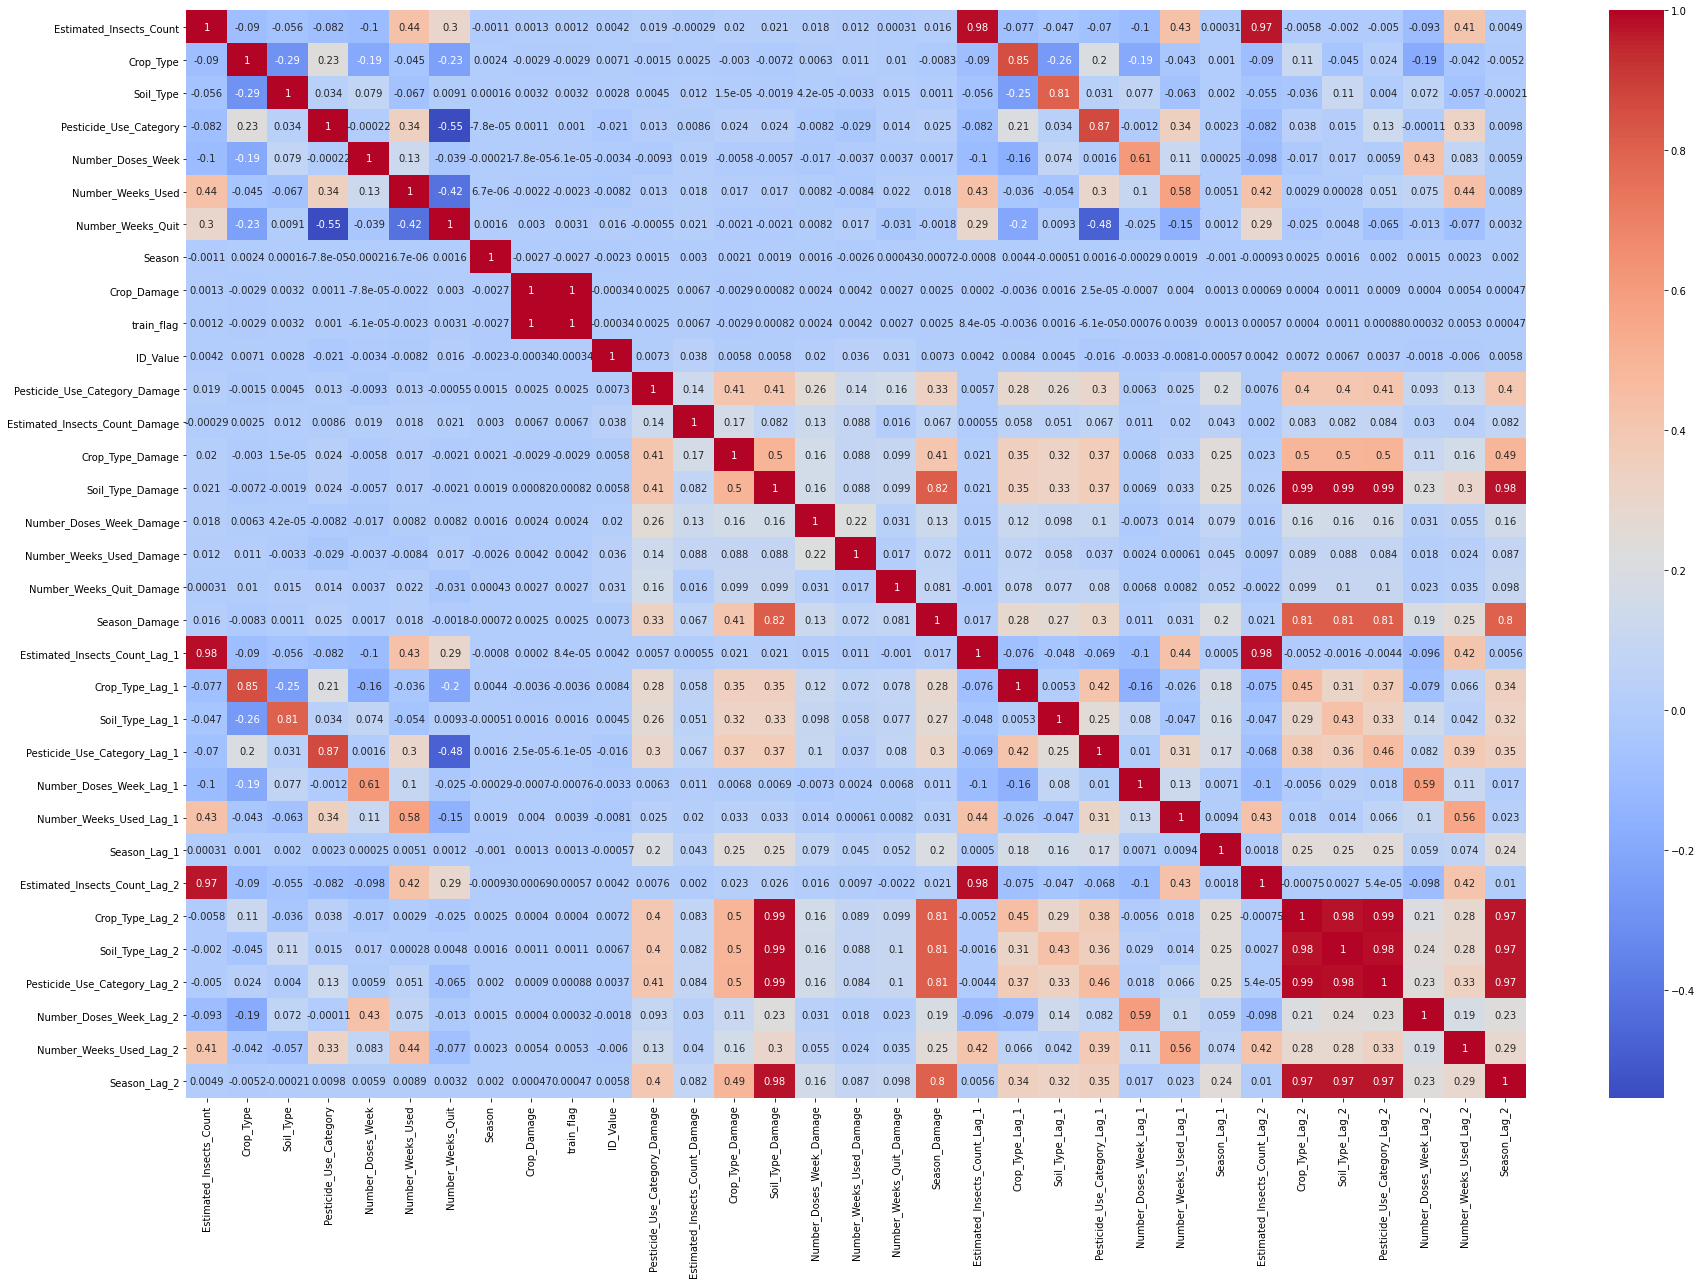

In [70]:
corr = data.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [71]:
data = data.drop(['Season_Damage'], axis=1)
data['Soil_Pesticide_Type_Damage'] = (data['Pesticide_Use_Category'] + data['Soil_Type_Damage'])/2
data = data.drop(['Soil_Type_Damage', 'Pesticide_Use_Category'], axis=1)

In [72]:
# Drop highly correlated features with Soil_Pesticide_Type_Damage
data = data.drop(['Crop_Type_Lag_2', 'Soil_Type_Lag_2', 'Pesticide_Use_Category_Lag_2', 'Season_Lag_2'], axis=1)

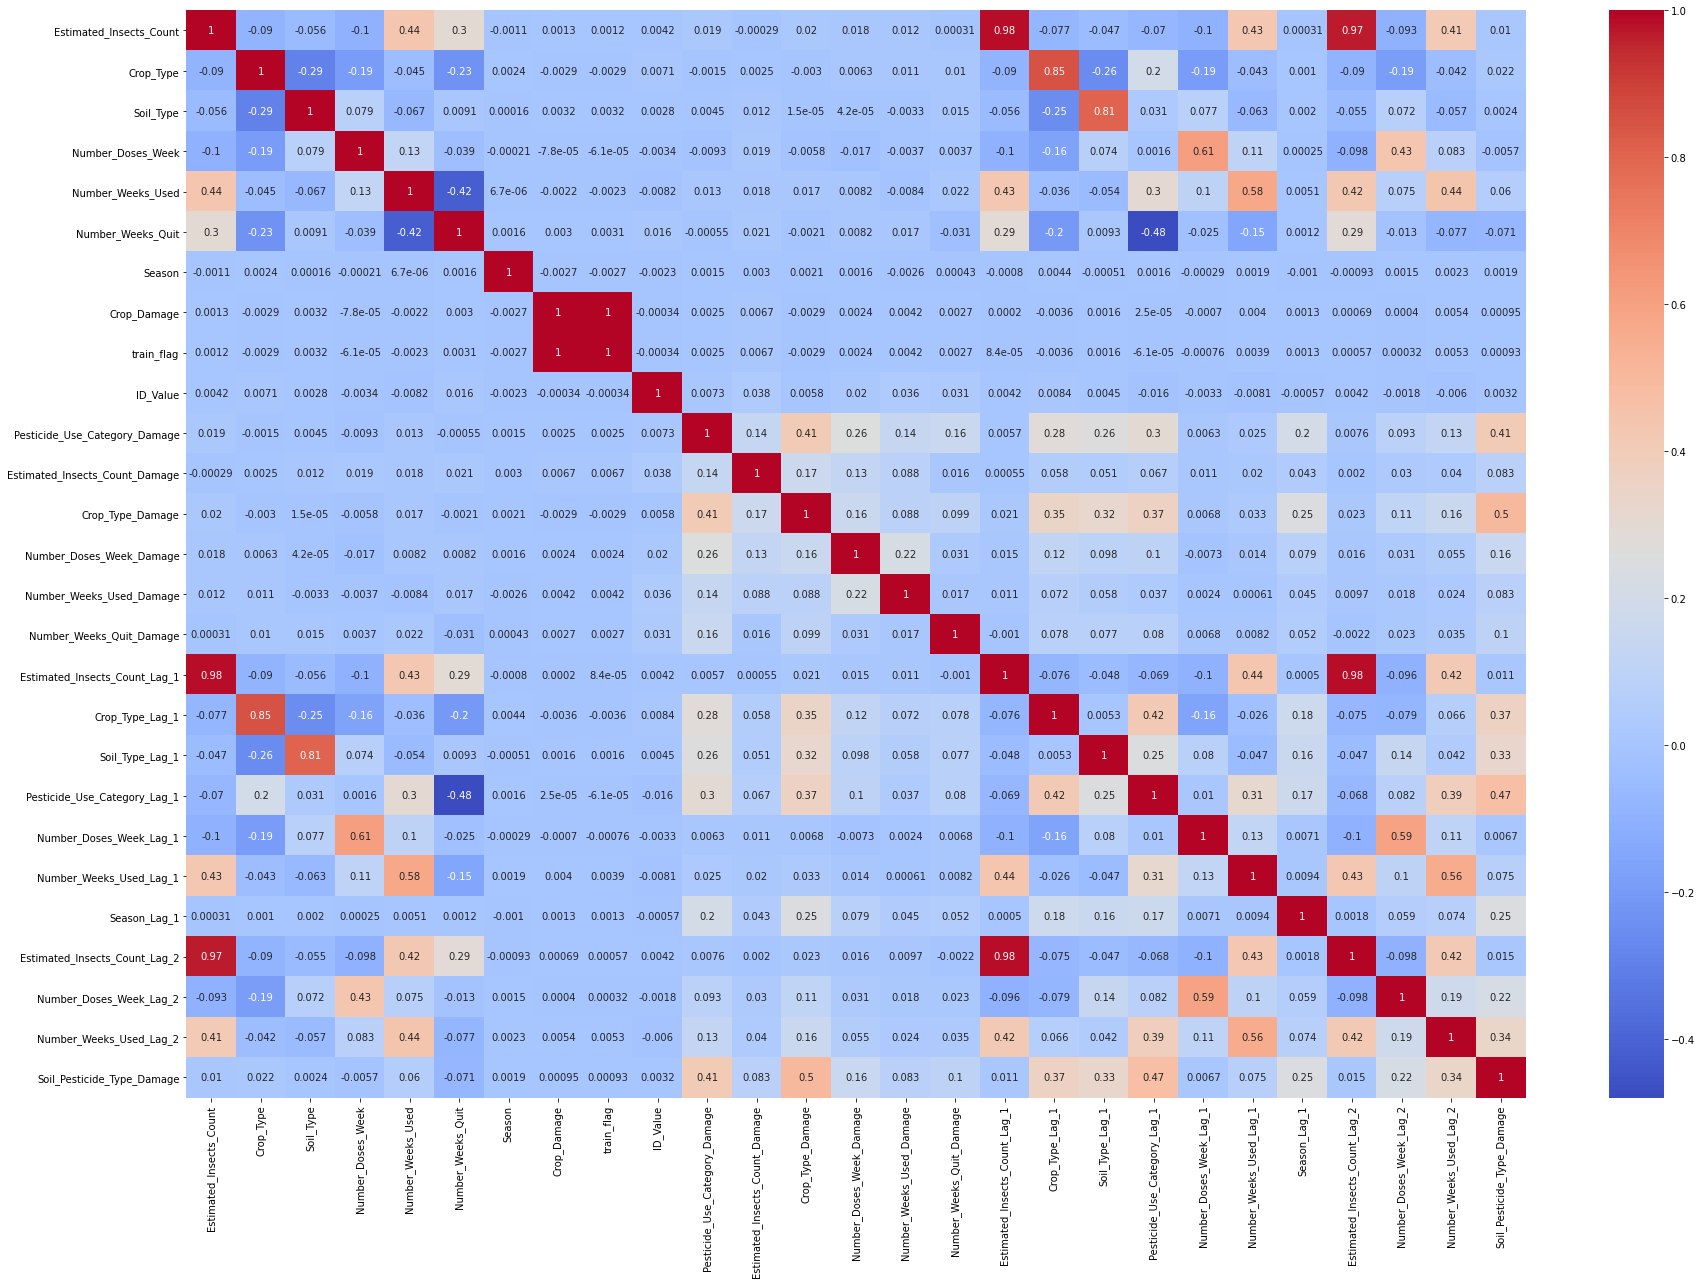

In [73]:
corr = data.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [74]:
data = data.drop(['Estimated_Insects_Count_Lag_1', 'Estimated_Insects_Count_Lag_2'], axis=1)

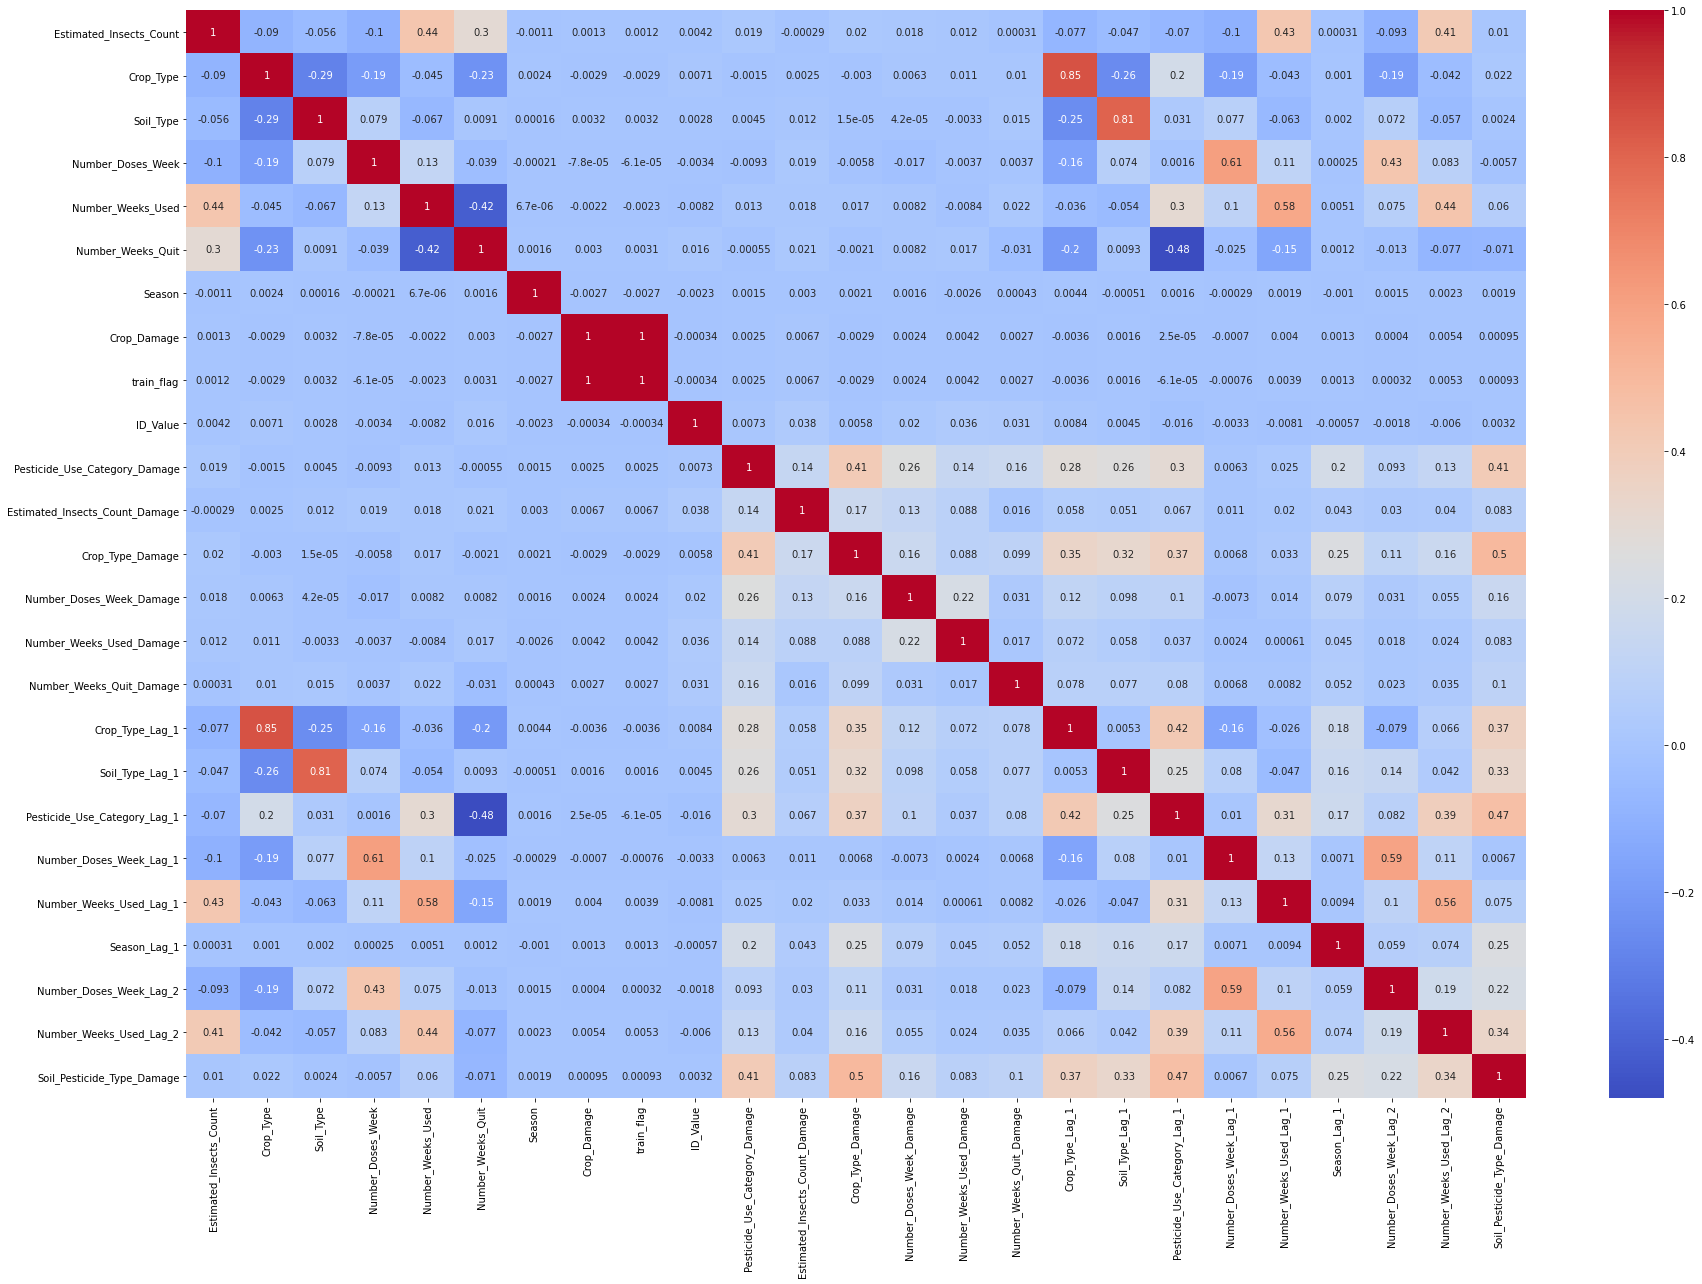

In [75]:
corr = data.corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [76]:
df_train, df_test = data[data.train_flag == 1], data[data.train_flag == 0]

In [77]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [78]:
print(df_train.shape, df_test.shape)

(88858, 25) (59310, 24)


In [80]:
df_test.columns

Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season',
       'ID_Value', 'Pesticide_Use_Category_Damage',
       'Estimated_Insects_Count_Damage', 'Crop_Type_Damage',
       'Number_Doses_Week_Damage', 'Number_Weeks_Used_Damage',
       'Number_Weeks_Quit_Damage', 'Crop_Type_Lag_1', 'Soil_Type_Lag_1',
       'Pesticide_Use_Category_Lag_1', 'Number_Doses_Week_Lag_1',
       'Number_Weeks_Used_Lag_1', 'Season_Lag_1', 'Number_Doses_Week_Lag_2',
       'Number_Weeks_Used_Lag_2', 'Soil_Pesticide_Type_Damage'],
      dtype='object')

In [81]:
df_train.columns

Index(['ID', 'Estimated_Insects_Count', 'Crop_Type', 'Soil_Type',
       'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season',
       'Crop_Damage', 'ID_Value', 'Pesticide_Use_Category_Damage',
       'Estimated_Insects_Count_Damage', 'Crop_Type_Damage',
       'Number_Doses_Week_Damage', 'Number_Weeks_Used_Damage',
       'Number_Weeks_Quit_Damage', 'Crop_Type_Lag_1', 'Soil_Type_Lag_1',
       'Pesticide_Use_Category_Lag_1', 'Number_Doses_Week_Lag_1',
       'Number_Weeks_Used_Lag_1', 'Season_Lag_1', 'Number_Doses_Week_Lag_2',
       'Number_Weeks_Used_Lag_2', 'Soil_Pesticide_Type_Damage'],
      dtype='object')

In [82]:
df_train, df_valid = train_test_split(df_train, test_size=0.30, random_state=42, shuffle=True, stratify=df_train[label_col])

In [83]:
df_train.shape

(62200, 25)

In [84]:
df_valid.shape

(26658, 25)

In [85]:
df_train.dtypes

ID                                 object
Estimated_Insects_Count             int64
Crop_Type                           int64
Soil_Type                           int64
Number_Doses_Week                   int64
Number_Weeks_Used                 float64
Number_Weeks_Quit                   int64
Season                              int64
Crop_Damage                         int64
ID_Value                            int64
Pesticide_Use_Category_Damage     float64
Estimated_Insects_Count_Damage    float64
Crop_Type_Damage                  float64
Number_Doses_Week_Damage          float64
Number_Weeks_Used_Damage          float64
Number_Weeks_Quit_Damage          float64
Crop_Type_Lag_1                     int64
Soil_Type_Lag_1                     int64
Pesticide_Use_Category_Lag_1        int64
Number_Doses_Week_Lag_1             int64
Number_Weeks_Used_Lag_1           float64
Season_Lag_1                        int64
Number_Doses_Week_Lag_2             int64
Number_Weeks_Used_Lag_2           

In [86]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_Value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Pesticide_Use_Category_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Number_Doses_Week_Damage', 'Number_Weeks_Used_Damage', 'Number_Weeks_Quit_Damage', 'Crop_Type_Lag_1', 'Soil_Type_Lag_1', 'Pesticide_Use_Category_Lag_1', 'Number_Doses_Week_Lag_1', 'Number_Weeks_Used_Lag_1', 'Season_Lag_1', 'Number_Doses_Week_Lag_2', 'Number_Weeks_Used_Lag_2', 'Soil_Pesticide_Type_Damage']


In [87]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category_Damage', 'Season', 'Crop_Type_Lag_1', 'Soil_Type_Lag_1', 'Pesticide_Use_Category_Lag_1', 'Season_Lag_1']

In [88]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11

In [89]:
clf = LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_valid[feature_cols], df_valid[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_valid[label_col], clf.predict(df_valid[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_Lag_1', 'Pesticide_Use_Category_Damage', 'Pesticide_Use_Category_Lag_1', 'Season', 'Season_Lag_1', 'Soil_Type', 'Soil_Type_Lag_1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_error: 0.164534	valid_0's multi_logloss: 0.504889	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.50516
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_error: 0.164534	valid_0's multi_logloss: 0.491337	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.492111
[3]	valid_0's multi_error: 0.164534	valid_0's multi_logloss: 0.478855	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.479821
[4]	valid_0's multi_error: 0.164534	valid_0's multi_logloss: 0.468092	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.469411
[5]	valid_0's multi_error: 0.164534	valid_0's multi_logloss: 0.458091	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.459786
[6]	valid_0's multi_error: 0.164534	valid_0's multi_logloss: 0.447548	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.449525
[7]	valid_0's multi_error: 0.164534	valid_0's multi_logloss: 0.438841	valid_1's multi_error: 0.164528	valid_1's multi_logl

In [90]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 914, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [91]:
df_train = pd.concat((df_train, df_valid))

In [92]:
clf = LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Crop_Type', 'Crop_Type_Lag_1', 'Pesticide_Use_Category_Damage', 'Pesticide_Use_Category_Lag_1', 'Season', 'Season_Lag_1', 'Soil_Type', 'Soil_Type_Lag_1']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


ACC: 0.9461612910486394


In [93]:
preds = clf.predict(df_test[feature_cols])

In [94]:
from collections import Counter
Counter(df_train['Crop_Damage'])
Counter(preds)

Counter({0: 50913, 1: 8065, 2: 332})

In [95]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Crop_Damage':preds})

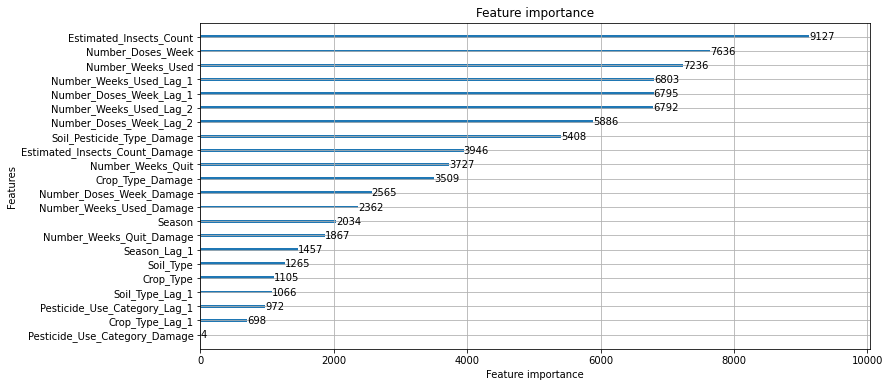

In [96]:
import lightgbm as lgb
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()

In [97]:
submission

,ID,Crop_Damage
1,F00000002,0
6,F00000007,1
10,F00000011,1
12,F00000013,1
13,F00000014,1
...,...,...
148159,F00155937,0
148162,F00155940,0
148163,F00155941,0
148165,F00155943,0


In [ ]:
submission.to_csv("Submit.csv", index=False)
from google.colab import files
files.download('Submit.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
pickle.dump(clf, open('model.pkl', 'wb'))

In [99]:
model = pickle.load(open('model.pkl', 'rb'))

In [ ]:
print(model.predict(['']))